# **Train EfficientNetB0**
----
- Training: Achieved 97.36% training accuracy by epoch 10 BUT the validation accuracy stayed low (23–34%), and loss was unstable. Could be severe overfitting. Not a good candidate for final use due to poor validation results.

---

In [8]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# will be using the cleaned data 
data_dir = 'tumor_data_cleaned'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# the augmented training data
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # 20% of training data for validation
)

# NO augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# here are the generators
train_gen = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [3]:
# EfficientNetB0 model 
def make_efficientnet_model(input_shape=(224,224,1), n_classes=4):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

    inputs = keras.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs])  # convert grayscale to 3 channels
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
# full model
efficientnet_model = make_efficientnet_model()
 
# train using the training generator / do val set 
efficientnet_history = efficientnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


572/572 ━━━━━━━━━━━━━━━━━━━━ 338s 549ms/step - accuracy: 0.7773 - loss: 0.5678 - val_accuracy: 0.2340 - val_loss: 1.8196
Epoch 2/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 304s 531ms/step - accuracy: 0.9246 - loss: 0.2092 - val_accuracy: 0.2805 - val_loss: 1510.2952
Epoch 3/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 303s 530ms/step - accuracy: 0.9321 - loss: 0.1866 - val_accuracy: 0.2796 - val_loss: 4.1120
Epoch 4/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 303s 530ms/step - accuracy: 0.9619 - loss: 0.1248 - val_accuracy: 0.2638 - val_loss: 30.0875
Epoch 5/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 299s 523ms/step - accuracy: 0.9677 - loss: 0.1058 - val_accuracy: 0.2805 - val_loss: 3.5707
Epoch 6/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 300s 524ms/step - accuracy: 0.9678 - loss: 0.1034 - val_accuracy: 0.2796 - val_loss: 7.1329
Epoch 7/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 299s 524ms/step - accuracy: 0.9644 - loss: 0.1051 - val_accuracy: 0.2699 - val_loss: 48.4633
Epoch 8/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 299s 522ms/step - accuracy: 0.9703 - loss:

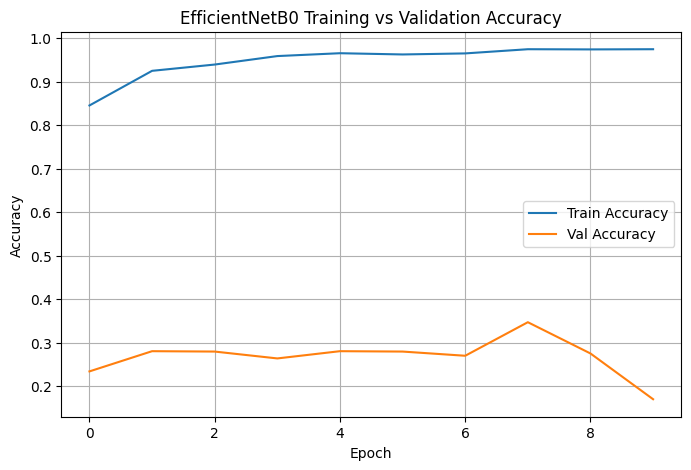

In [6]:
# plot the learning curves
plt.figure(figsize=(8, 5))
plt.plot(efficientnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(efficientnet_history.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Save the trained model 
efficientnet_model.save('efficientnetb0_augmented_model.h5')

with open('efficientnetb0_augmented_history.pkl', 'wb') as f:
    pickle.dump(efficientnet_history.history, f)